In [90]:
# import mne

from pathlib import Path

import mne
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from src.dataset_utils import build_manifest_simple, save_manifest

standardize: lambda x: (x - x.mean()) / x.std()

## 1. Load an EEG-recording

In [7]:
manifest = pd.read_csv("C:/Users/MDBI/Documents/public-datasets/sleepy-rat/manifest.csv")      # or use your in-memory df

row = manifest.iloc[0]
raw = mne.io.read_raw_edf(str(row['edf_path']), preload=True, stim_channel=None, verbose=False)

eeg_like = [ch for ch in raw.ch_names if "EEG" in ch.upper()]
emg_like = [ch for ch in raw.ch_names if "EMG" in ch.upper()]
raw.set_channel_types({ch: "eeg" for ch in eeg_like})
raw.set_channel_types({ch: "emg" for ch in emg_like})
sfreq = raw.info["sfreq"]

raw

<RawEDF | A1.edf, 3 x 11059200 (86400.0 s), ~253.1 MB, data loaded>

In [ ]:
print(raw.info["sfreq"])  # sampling rate (Hz)
print(raw.info["ch_names"])

<RawEDF | A1.edf, 3 x 11059200 (86400.0 s), ~253.1 MB, data loaded>
128.0
['EEG1', 'EEG2', 'EMG']


In [12]:
eeg_band = (0.5, 50)   # Hz
line_freq = 50.0       # set 60.0 if needed
raw_f = raw.copy()
raw_f.notch_filter([line_freq])
picks_eeg = mne.pick_types(raw_f.info, eeg=True, emg=False)
raw_f.filter(eeg_band[0], eeg_band[1], picks=picks_eeg)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edg

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished


<RawEDF | A1.edf, 3 x 11059200 (86400.0 s), ~253.1 MB, data loaded>

In [23]:
# pick a short window, e.g., 2 minutes starting at 6.0 h
start_h, duration_h = 6.0, 0.0333  # 0.0333 h ~ 2 min
start, stop = start_h*3600, (start_h+duration_h)*3600

raw_win = raw_f.copy().crop(tmin=start, tmax=stop)
#epochs_small = mne.make_fixed_length_epochs(raw_win, duration=4.0, preload=True, overlap=0.0)

In [ ]:
raw_f.crop(tmin=0, tmax=600)  # first 10 minute

np.int64(0)

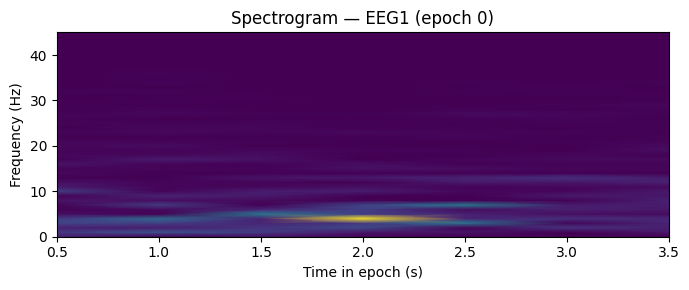

In [ ]:
from scipy.signal import spectrogram
import matplotlib.pyplot as plt


sfreq = epochs_small.info["sfreq"]
pick = mne.pick_types(epochs_small.info, eeg=True)[0]   # first EEG channel
x = epochs_small.get_data(picks=[pick])[:, 0, :]        # (n_epochs, n_times)

nperseg = int(round(1.0 * sfreq))
noverlap = int(round(0.5 * sfreq))
f, t, Sxx = spectrogram(x[0], fs=sfreq, nperseg=nperseg, noverlap=noverlap,
                        detrend=False, scaling="density", mode="psd")

plt.figure(figsize=(7, 3))
plt.pcolormesh(t, f, Sxx, shading="gouraud")
plt.ylabel("Frequency (Hz)"); plt.xlabel("Time in epoch (s)")
plt.title(f"Spectrogram — {epochs_small.ch_names[pick]} (epoch 0)")
plt.ylim(0, 45); plt.tight_layout(); plt.show()

Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).


C:\Users\MDBI\AppData\Local\Temp\ipykernel_16604\1583088602.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_win.compute_psd(fmax=50).plot(picks="data", exclude="bads", amplitude=False)
c:\Users\MDBI\AppData\Local\miniforge3\envs\eeg-data-env\lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


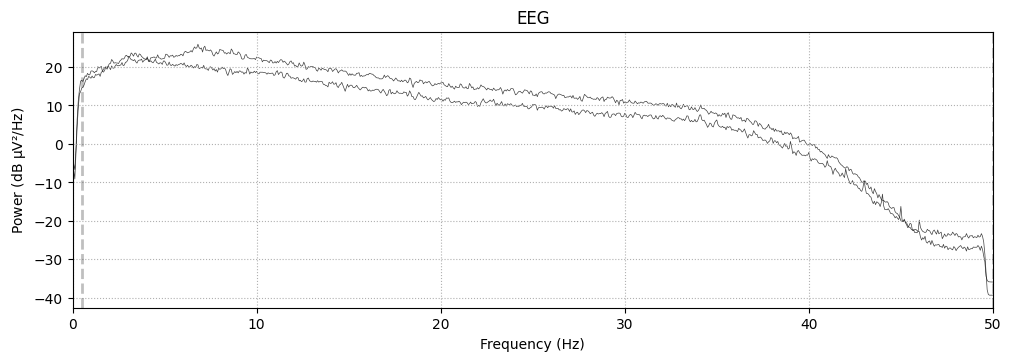

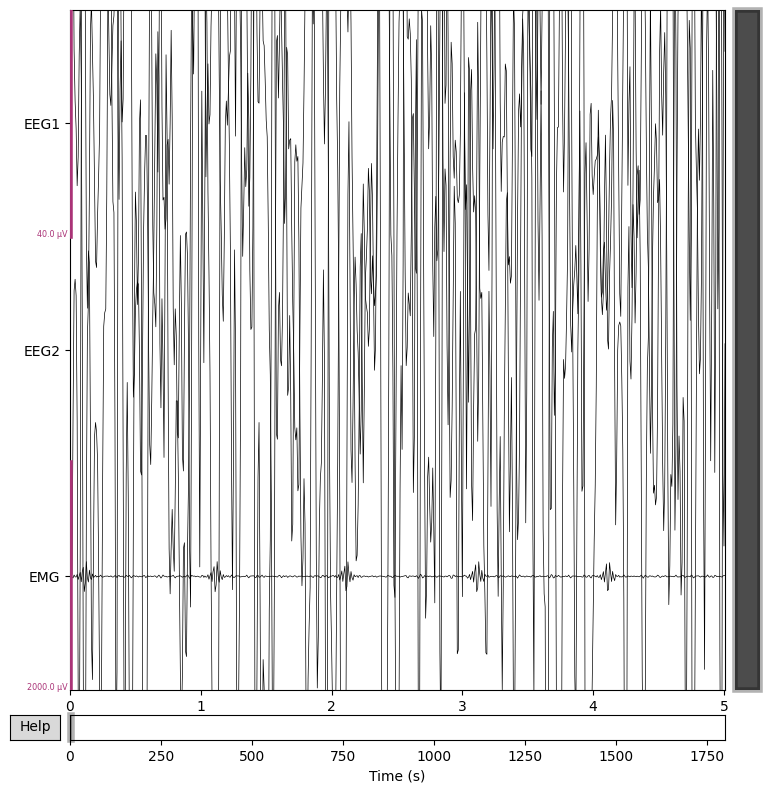

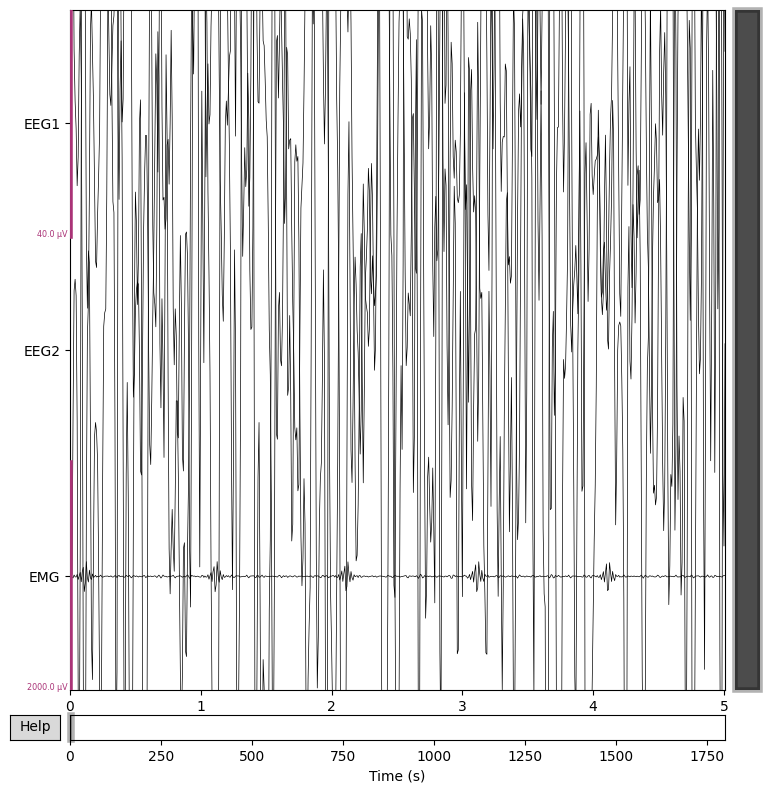

In [16]:
raw_win.compute_psd(fmax=50).plot(picks="data", exclude="bads", amplitude=False)
raw_win.plot(duration=5, n_channels=30)

## 2. Scipy version

In [91]:
import pyedflib

manifest = pd.read_csv("C:/Users/MDBI/Documents/public-datasets/sleepy-rat/manifest.csv")      # or use your in-memory df
row = manifest.iloc[0]
edf_path = row['edf_path']
scoring_path = row['scoring_path']

with pyedflib.EdfReader(edf_path) as f:
    n = f.signals_in_file
    ch_names = f.getSignalLabels()
    fs_list = np.array([f.getSampleFrequency(i) for i in range(n)], dtype=float)
    signals = [f.readSignal(i).astype(float) for i in range(n)]


x = signals[0]
fs = fs_list[0]

In [92]:
x.shape, n, ch_names, fs_list

((11059200,), 3, ['EEG1', 'EEG2', 'EMG'], array([128., 128., 128.]))

In [93]:
scorings = pd.read_csv(scoring_path, index_col=0, names = ["score_1", "score_2"])
scorings.shape

(21600, 2)

In [94]:
x.shape[0]/(fs*4)

np.float64(21600.0)

### Filter signal (denoise)

In [95]:
from scipy.signal import iirnotch, butter, filtfilt, spectrogram

def bandpass_filtfilt(x, fs, f_lo=0.5, f_hi=45.0, order=4):
    """Zero-phase Butterworth bandpass."""
    b, a = butter(order, [f_lo/(fs/2.0), f_hi/(fs/2.0)], btype="bandpass")
    return filtfilt(b, a, x)

In [96]:
x_filtered = bandpass_filtfilt(x, fs, f_lo=0.5, f_hi=45.0, order=4)
x_filtered.shape

(11059200,)

### Make epochs (4s)

In [97]:
import numpy as np

def make_epochs_1d(x, fs, epoch_len_s=4.0, start_s=0.0, return_starts=True):
    x = np.asarray(x)
    sp_epoch  = int(round(epoch_len_s * fs))          # samples per epoch
    start_idx = int(round(start_s * fs))              # align to scorer grid
    stop_idx  = start_idx + ((len(x) - start_idx) // sp_epoch) * sp_epoch
    x_seg = x[start_idx:stop_idx]                     # exact multiple of sp_epoch
    epochs = x_seg.reshape(-1, sp_epoch)              # (n_epochs, sp_epoch)
    if return_starts:
        starts = start_idx + np.arange(len(epochs)) * sp_epoch
        return epochs, sp_epoch, len(epochs), starts
    return epochs, sp_epoch, len(epochs)

In [98]:
epochs_eeg, sp_epoch, n_epochs, starts = make_epochs_1d(x_filtered, fs, epoch_len_s=4.0, start_s=0.0)
print(epochs_eeg.shape)   # (21600, 512)  <- expected
print(epochs_eeg.size, x.size)  # equal (just reshaped)

(21600, 512)
11059200 11059200


### Frequeny analysis of an epoch

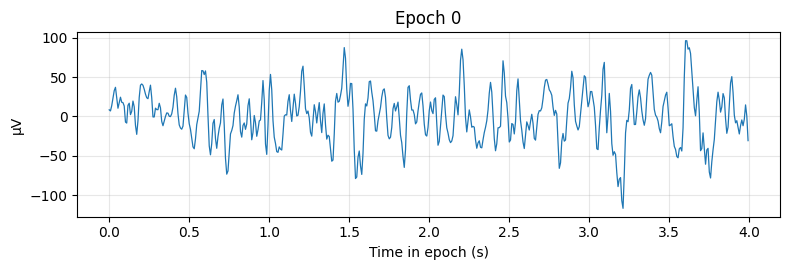

In [99]:
def plot_epoch(epoch, fs, title=None):
    t = np.arange(len(epoch)) / fs
    plt.figure(figsize=(8, 2.8))
    plt.plot(t, epoch, lw=0.9)
    plt.xlabel("Time in epoch (s)"); plt.ylabel("µV")
    if title: plt.title(title)
    plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# Example for epoch i
i = 0
plot_epoch(epochs_eeg[i], fs, title=f"Epoch {i}")

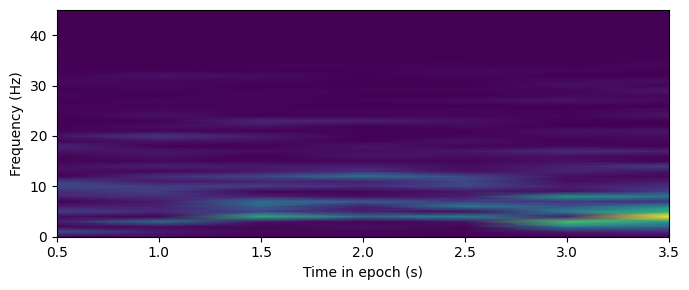

In [100]:
# Spectrogram of epoch 0
from scipy.signal import spectrogram
f, t, Sxx = spectrogram(epochs_eeg[i], fs=fs, nperseg=int(fs*1.0), noverlap=int(fs*0.5),
                        detrend=False, scaling="density", mode="psd")

plt.figure(figsize=(7, 3))
plt.pcolormesh(t, f, Sxx, shading="gouraud")
plt.ylabel("Frequency (Hz)"); plt.xlabel("Time in epoch (s)")
plt.ylim(0, 45); plt.tight_layout(); plt.show()

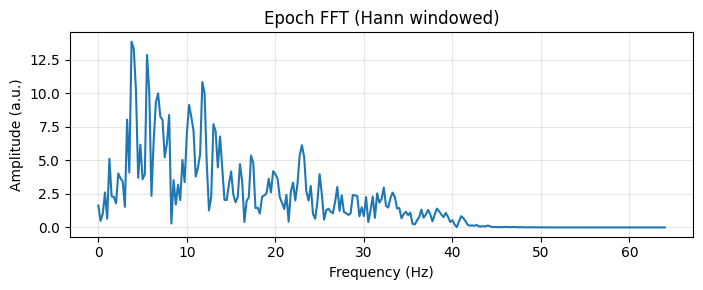

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq


y = np.asarray(epochs_eeg[i], float)
y = y - y.mean()                     # remove DC
N = y.size
T = 1.0 / fs

# Window to reduce leakage (Hann) + amplitude correction
w = np.hanning(N)
y_win = y * w
Y = rfft(y_win)
f = rfftfreq(N, T)                   # positive freqs

# Amplitude spectrum (one-sided). Correct for window loss.
U = w.mean()                         # amplitude loss factor of Hann window
amp = (2.0 / (N * U)) * np.abs(Y)    # amplitude per Hz bin (not PSD)

plt.figure(figsize=(7, 3))
plt.plot(f, amp)
plt.ylabel("Amplitude (a.u.)")
plt.xlabel("Frequency (Hz)")
plt.title("Epoch FFT (Hann windowed)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
